In [2]:
import pandas as pd

articles = pd.read_csv('articles.tsv', sep='\t')
print(articles)

title  \
0    제주항공 "열흘내에 선행조건 다 해결해라"…사실상 파기수순   
1      이 앱 열면…한국 10대들 개인정보 중국으로 줄줄 샌다   
2  “예수가 레즈비언?” 마이클 잭슨 딸 출연 영화 신성모독 논란   

                                                body  
0  제주항공이 이스타항공 측에 "10일 이내에 선결 조건을 모두 이행하지 않으면 계약을...  
1  지난해 5월 미국 코네티컷주 한 마을에 거주하고 있는 14살 소녀 찰리 다멜리오는 ...  
2  마이클 잭슨의 딸 패리스 잭슨(22)이 ‘예수 그리스도’로 출연한 영화가 ‘신성 모...  


In [3]:
def pre_processing(text: str) -> str:
    return "SOT " + text + " EOT"

articles['title'] = articles['title'].apply(pre_processing)
articles['body'] = articles['body'].apply(pre_processing)
print(articles)

title  \
0    SOT 제주항공 "열흘내에 선행조건 다 해결해라"…사실상 파기수순 EOT   
1      SOT 이 앱 열면…한국 10대들 개인정보 중국으로 줄줄 샌다 EOT   
2  SOT “예수가 레즈비언?” 마이클 잭슨 딸 출연 영화 신성모독 논란 EOT   

                                                body  
0  SOT 제주항공이 이스타항공 측에 "10일 이내에 선결 조건을 모두 이행하지 않으면...  
1  SOT 지난해 5월 미국 코네티컷주 한 마을에 거주하고 있는 14살 소녀 찰리 다멜...  
2  SOT 마이클 잭슨의 딸 패리스 잭슨(22)이 ‘예수 그리스도’로 출연한 영화가 ‘...  


In [4]:
from PyKomoran import Komoran
k = Komoran('EXP')

titles = [k.get_morphes_by_tags(title) for title in articles['title']]
print(titles)

bodies = [k.get_morphes_by_tags(body) for body in articles['body']]
print(bodies)

[['SOT', '제주항공', '"', '열흘', '내', '에', '선행', '조건', '다', '해결', '하', '아라', '"', '…', '사실', '상', '파기', '수순', 'EOT'], ['SOT', '이', '앱', '열', '면', '…', '한국', '10대', '들', '개인정보', '중국', '으로', '줄줄', '새', 'ㄴ다', 'EOT'], ['SOT', '“', '예수', '가', '레즈비언', '?', '”', '마이클 잭슨', '딸', '출연', '영화', '신성모독', '논란', 'EOT']]
[['SOT', '제주항공', '이', '이스타항공', '측', '에', '"', '10', '일', '이내', '에', '선결', '조건', '을', '모두', '이행', '하', '지', '않', '으면', '계약', '을', '해지', '하', '겠', '다', '"', '는', '취지', '의', '공문', '을', '보내', 'ㄴ', '것', '으로', '확인', '되', '었', '다', '.', '대부분', '유동성', '과', '관련', '되', 'ㄴ', '조건', '이', '어서', '현재', '돈줄', '이', '막히', 'ㄴ', '이스타항공', '이', '자체', '적', '으로', '기간', '내', '에', '해결', '하', '기', '힘들', 'ㄴ', '만큼', '사실', '상', '계약', '파기', '수순', '을', '밟', '게', '되', 'ㄹ', '것', '으로', '보이', 'ㄴ다', '.', '2', '일', '항공업', '계', '에', '따르', '면', '제주항공', '은', '지난달', '30', '일', '이스타항공', '이', '보내', 'ㄴ', '선결', '과제', '이행', '과', '관련', '하', 'ㄴ', '공문', '에', '대하', '아', '전날', '밤', '이', '같', '은', '답변', '을', '보내', 'ㄴ', '것', '으로', '알리', '어', '지'

In [5]:
max_title_morphemes = max([len(title) for title in titles])
print(max_title_morphemes)

max_body_morphemes = max([len(body) for body in bodies])
print(max_body_morphemes)

data_size = len(titles)
print(data_size)

19
2002
3


In [6]:
from typing import List

def padding(lst: List[str], max_len: int) -> List[str]:
    return lst + ['EOT'] * (max_len - len(lst))

titles = [padding(title, max_title_morphemes) for title in titles]
print(titles)

bodies = [padding(body, max_body_morphemes) for body in bodies]
print(bodies)

도', '예외', '가', '아니', '다', '.', '지나', 'ㄴ', '2', '월', '21', '일', '인기', '아이돌', '그룹', '방탄소년단', '(', 'BTS', ')', '은', '정규', '4', '집', '앨범', '타이틀', '곡', "'", 'ON', "'", '일부', '를', '틱톡', '에', '공개', '하', '았', '는데', ',', '개시', '60', '시간', '만', '에', '1억뷰를', '돌파', '하', '았', '다', '.', 'BTS', '멤버', '정국', '의', '콘텐츠', '는', '지난달', '세계', '최초', '로', '100억뷰를', '기록', '하', '았', '다', '.', '아이돌', '블랙', '핑크', ',', '트와이스', ',', '세븐틴', ',', '선미', ',', '백현', ',', '영', '탁', ',', '우주소녀', '등', '도', '컴백', '을', '앞두', '고', '모두', '틱톡', '영상', '을', '업로드', '하', '았', '다', '.', '국내', '일반', '대중', '사이에서', '는', '올', '초', '가수', '지코', '가', '마마무', '의', '화사', ',', '청하', ',', '산다', '라박', '등', '과', '커플', '채', 'ㄹ', '린지', '영상', '을', '찍', '은', '것', '을', '계기', '로', '급속도', '로', '확산', '되', '었', '다', '.', '\n', '하루', '영화', '35', '만', '편', '분량', '데이터', '빨아들이', '는', "'", '틱톡', "'", '\n', '틱톡', '은', '올', '초', '코로나', '바이러스', '감염증', '(', '코로나', '19', ')', '의', '팬데믹', '(', '세계', '적', '대', '유행', ')', '영향', '으로', '집', '에서', '생활', '하', '는', '사람', '

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(titles)
tokenizer.fit_on_texts(bodies)

num_of_morphemes = len(tokenizer.word_counts) + 1
print(num_of_morphemes)

title_sequence = np.array(tokenizer.texts_to_sequences(titles))
print(title_sequence)

body_sequence = np.array(tokenizer.texts_to_sequences(bodies))
print(body_sequence)

974
[[ 70  50  34 142  83   9 339  84   5  85   2 340  34 194 104  86 195 196
    1]
 [ 70   3 105 341  87 194 197 198  40 342  48  17 343 344  41   1   1   1
    1]
 [ 70  88  43  14 106 199 107 143 144  71  37 345  56   1   1   1   1   1
    1]]
[[ 70  50   3 ...   1   1   1]
 [ 70  75 119 ...   5   4   1]
 [ 70 143  10 ...   1   1   1]]


In [8]:
embedding_dim = 256
hidden_size = 128
encoder_layer_size = 1
learning_late = 0.001
dropout = 0.4

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Attention, Concatenate, Dense
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

# Encoder Input
encoder_inputs = Input(shape=(max_body_morphemes,), name='encoder_inputs')

# Encoder Embedding Layer
encoder_embedding = Embedding(
    num_of_morphemes, 
    embedding_dim, 
    name='encoder_embedding_layer'
)(encoder_inputs)

# Encoder Layer
encoder_outputs, encoder_states = None, None
for i in range(encoder_layer_size):
    encoder_layer = GRU(
        units=hidden_size,
        return_sequences=True, return_state=True,
        dropout=dropout, recurrent_dropout=dropout,
        name='encoder_layer_' + str(i + 1)
    )
    encoder_outputs, encoder_states = encoder_layer(
        encoder_embedding if encoder_outputs is None else encoder_outputs
    )

# Decoder
decoder_inputs = Input(shape=(None,), name='decoder_inputs')

# Decoder Embedding Layer
decoder_embedding_layer = Embedding(
    num_of_morphemes, 
    embedding_dim, 
    name='decoder_embedding_layer'
)
decoder_embedding = decoder_embedding_layer(decoder_inputs)

# Decoder Layer
decoder_layer = GRU(
    hidden_size,
    return_sequences=True, return_state=True,
    dropout=dropout, recurrent_dropout=dropout / 2,
    name='decode_layer'
)
decoder_outputs, _ = decoder_layer(
    decoder_embedding,
    initial_state=encoder_states
)

# Attention Layer
attention_layer = Attention(name='attention_layer')
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])

# Concatenate the Result of Attention and the Hidden States of Decoder
decoder_concat_inputs = Concatenate(axis=-1, name='concatenate_layer')(
    [decoder_outputs, attention_outputs]
)

# Output Layer
output_layer = Dense(num_of_morphemes, activation=softmax, name='output_layer')
outputs = output_layer(decoder_concat_inputs)

# Define Model
model = Model(
    inputs=[encoder_inputs, decoder_inputs], 
    outputs=outputs,
    name='training_model'
)
model.summary()

# Compile
model.compile(
    optimizer=Adam(learning_rate=learning_late),
    loss=sparse_categorical_crossentropy
)

Model: "training_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 2002)]       0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_embedding_layer (Embedd (None, 2002, 256)    249344      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_embedding_layer (Embedd (None, None, 256)    249344      decoder_inputs[0][0]             
_____________________________________________________________________________________

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    body_sequence, title_sequence, test_size=0.33
)
print(x_train)
print(x_test)
print(y_train)
print(y_test)

[[ 70  50   3 ...   1   1   1]
 [ 70 143  10 ...   1   1   1]]
[[ 70  75 119 ...   5   4   1]]
[[ 70  50  34 142  83   9 339  84   5  85   2 340  34 194 104  86 195 196
    1]
 [ 70  88  43  14 106 199 107 143 144  71  37 345  56   1   1   1   1   1
    1]]
[[ 70   3 105 341  87 194 197 198  40 342  48  17 343 344  41   1   1   1
    1]]


In [10]:
epochs = 50
batch_size = 1

history = model.fit(
    [x_train, y_train[:, :-1]], y_train[:, 1:],
    epochs=epochs, batch_size=batch_size,
    validation_data=([x_test, y_test[:, :-1]], y_test[:, 1:])
)

Train on 2 samples, validate on 1 samples
Epoch 1/50
2/2 [==============================] - 8s 4s/sample - loss: 6.8810 - val_loss: 6.8778
Epoch 2/50
2/2 [==============================] - 4s 2s/sample - loss: 6.8542 - val_loss: 6.8682
Epoch 3/50
2/2 [==============================] - 4s 2s/sample - loss: 6.8123 - val_loss: 6.8585
Epoch 4/50
2/2 [==============================] - 4s 2s/sample - loss: 6.7681 - val_loss: 6.8462
Epoch 5/50
2/2 [==============================] - 4s 2s/sample - loss: 6.6991 - val_loss: 6.8292
Epoch 6/50
2/2 [==============================] - 4s 2s/sample - loss: 6.6026 - val_loss: 6.8078
Epoch 7/50
2/2 [==============================] - 4s 2s/sample - loss: 6.4527 - val_loss: 6.7775
Epoch 8/50
2/2 [==============================] - 4s 2s/sample - loss: 6.2264 - val_loss: 6.7331
Epoch 9/50
2/2 [==============================] - 4s 2s/sample - loss: 5.7988 - val_loss: 6.6626
Epoch 10/50
2/2 [==============================] - 4s 2s/sample - loss: 5.1999 - val_

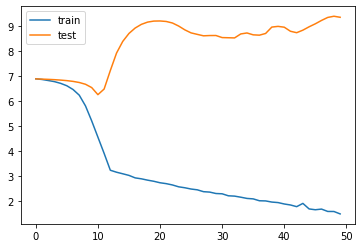

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [12]:
# Define Encoder Model
encoder_model = Model(
    inputs=encoder_inputs,
    outputs=[encoder_outputs, encoder_states],
    name='encoder_model'
)
encoder_model.summary()

# Decoder
decoder_states_input = Input(
    shape=(hidden_size,),
    name='decoder_states_input'
)

decoder_embedding_predict = decoder_embedding_layer(decoder_inputs)
decoder_outputs_predict, decoder_states_predict = decoder_layer(
    decoder_embedding_predict,
    initial_state=decoder_states_input
)

# Attention
decoder_hidden_states_input = Input(
    shape=(max_body_morphemes, hidden_size), 
    name='decoder_hidden_states_input'
)
attention_outputs_predict = attention_layer(
    [decoder_outputs_predict, decoder_hidden_states_input]
)
decoder_concat_predict = Concatenate(axis=-1, name='decoder_concatenate_predict')(
    [decoder_outputs_predict, attention_outputs_predict]
)

# Output Layer
outputs_predict = output_layer(decoder_concat_predict)

# Define Decoder Model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_states_input, decoder_states_input],
    [decoder_outputs_predict] + [decoder_states_predict],
    name='decoder_model'
)
decoder_model.summary()

Model: "encoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 2002)]            0         
_________________________________________________________________
encoder_embedding_layer (Emb (None, 2002, 256)         249344    
_________________________________________________________________
encoder_layer_1 (GRU)        [(None, 2002, 128), (None 148224    
Total params: 397,568
Trainable params: 397,568
Non-trainable params: 0
_________________________________________________________________
Model: "decoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     [(None, None)]       0                                            
_________________________________________________________

In [13]:
def encoding(text: str) -> np.ndarray:
    separated = k.get_morphes_by_tags(text)
    separated = padding(separated, max_body_morphemes)
    sequence = np.array(tokenizer.texts_to_sequences([separated]))
    return sequence

def predict(body: str) -> str:
    input_seq = encoding(body)
    e_out, e_h = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['sot']

    decoded_sentence = ''
    while True:
        output_tokens, h = decoder_model.predict(
            [target_seq] + [e_out, e_h]
        )
        sampled_token_index = np.argmax(output_tokens[0, -1, 1:])
        sampled_token = tokenizer.index_word[sampled_token_index]

        if sampled_token != 'eot':
            decoded_sentence += ' ' + sampled_token
        else:
            break

        if len(decoded_sentence.split()) >= max_title_morphemes - 1:
            break

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        e_h = h

    return decoded_sentence

result = [predict(body) for body in articles['body']]
for title in result:
    print(title)


에서 유튜브 유튜브 > > 있 있 있 의 의 의 의 에 에 에 에 에 에
 에서 유튜브 유튜브 유튜브 > 있 있 있 의 의 의 의 에 에 에 에 에 에
 에서 유튜브 유튜브 > > 있 있 있 의 의 의 의 에 에 에 에 에 에
